In [1]:
import tensorflow as tf 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import array_to_img
# from sklearn.model_selection import train_test_split
# from PIL import Image
# import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot
from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

# from tqdm import tqdm, tqdm_notebook
# from colorama import Fore
# import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
# import time
# from sklearn.decomposition import PCA
# from sklearn.svm import LinearSVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import lightgbm as lgb
# import xgboost as xgb
# !pip install livelossplot
# import livelossplot
# from livelossplot import PlotLossesKeras
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

All modules have been imported


In [3]:
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob

%matplotlib inline 

In [6]:
import os
base_image_dir = os.path.join('.', '../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped')
df = pd.read_csv(os.path.join('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists)
# Most of the files do not exist because this is a sample of the original dataset



df = df[df['exists']]
print(df[df['exists']])
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True)     # Shuffle Dataframe
df['level'] = df['level'].astype(str)
df.head(10)

       Unnamed: 0  Unnamed: 0.1        image  level  \
0               0             0      10_left      0   
1               1             1     10_right      0   
2               2             2      13_left      0   
3               3             3     13_right      0   
4               4             4      15_left      1   
...           ...           ...          ...    ...   
35103       35104         35121  44347_right      0   
35104       35105         35122   44348_left      0   
35105       35106         35123  44348_right      0   
35106       35107         35124   44349_left      0   
35107       35108         35125  44349_right      1   

                                                    path  exists  
0      ./../input/diabetic-retinopathy-resized/resize...    True  
1      ./../input/diabetic-retinopathy-resized/resize...    True  
2      ./../input/diabetic-retinopathy-resized/resize...    True  
3      ./../input/diabetic-retinopathy-resized/resize...    True  
4   

,Unnamed: 0,Unnamed: 0.1,level,path
0,15349,15359,0,./../input/diabetic-retinopathy-resized/resize...
1,18234,18246,0,./../input/diabetic-retinopathy-resized/resize...
2,32070,32086,0,./../input/diabetic-retinopathy-resized/resize...
3,4959,4963,0,./../input/diabetic-retinopathy-resized/resize...
4,12001,12008,0,./../input/diabetic-retinopathy-resized/resize...
5,35102,35119,0,./../input/diabetic-retinopathy-resized/resize...
6,17055,17066,0,./../input/diabetic-retinopathy-resized/resize...
7,12489,12498,0,./../input/diabetic-retinopathy-resized/resize...
8,556,556,3,./../input/diabetic-retinopathy-resized/resize...
9,11266,11273,0,./../input/diabetic-retinopathy-resized/resize...


<AxesSubplot:>

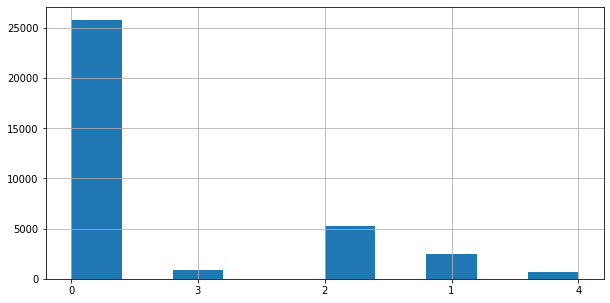

In [7]:
df['level'].hist(figsize = (10, 5))

In [8]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

7022

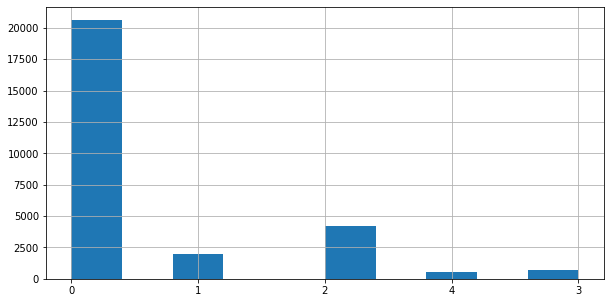

In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set
train_df['level'].hist(figsize = (10, 5))
len(val_df)

New Data Size: 103180 Old Size: 28086


<AxesSubplot:>

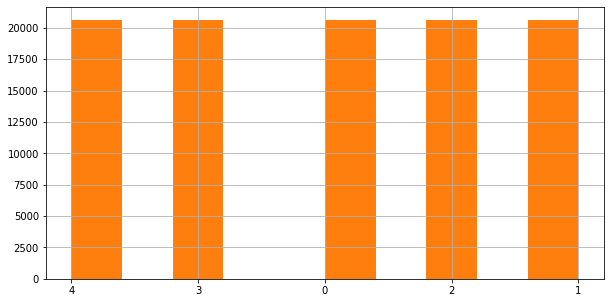

In [10]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [11]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

110202

In [12]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip = True,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2
)

In [13]:
x_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=".",
        x_col="path",
        y_col="level",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')
x_test = test_datagen.flow_from_dataframe(
        val_df,
        x_col="path",
        y_col="level",
        directory=".",
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical')

Found 103180 validated image filenames belonging to 5 classes.
Found 7022 validated image filenames belonging to 5 classes.


In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
t_x, t_y = next(x_train)

In [19]:
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_depth = 2048
pt_features = base_pretrained_model(in_lay)
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
model.summary()

2022-11-09 18:18:19.185166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:18:19.186098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:18:19.658341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:18:19.659666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-09 18:18:19.660842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
_____________________________

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Functional)       (None, 6, 6, 2048)   21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 6, 6, 2048)   8192        inception_v3[0][0]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 6, 6, 2048)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

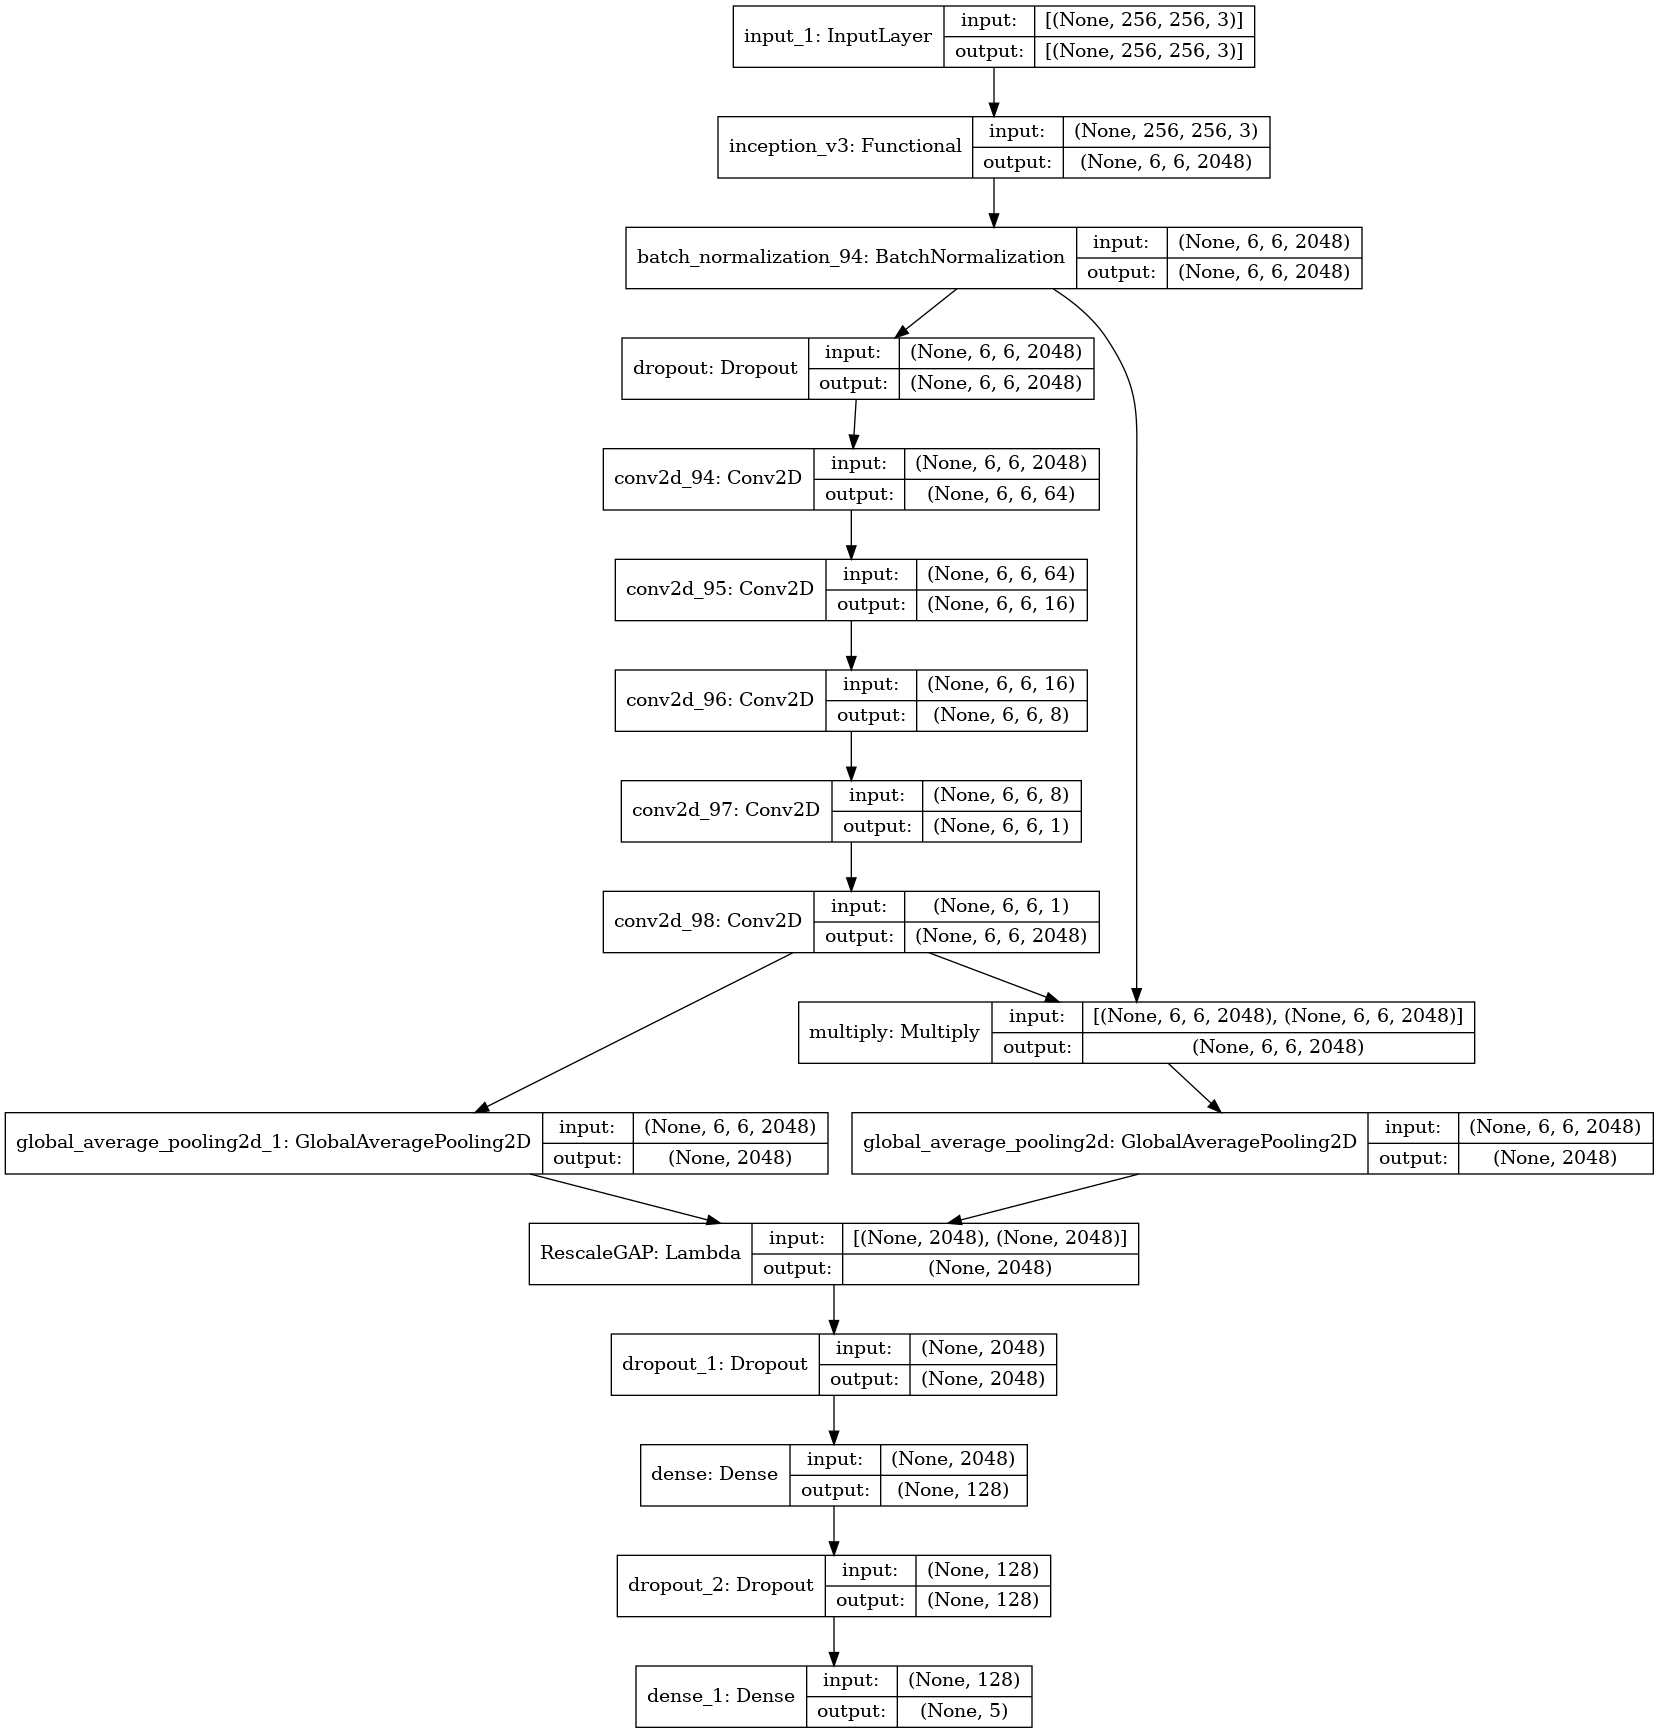

In [21]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [22]:
filepath = "dr-detector.hdf5"
checkpoint = ModelCheckpoint(filepath,
                             monitor="val_top2_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          verbose=1, 
                          min_delta=0, 
                          patience=15, 
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              verbose=1,
                              factor=0.2, 
                              patience=6, 
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0.001)


callbacks = [checkpoint, earlystop, reduce_lr]

In [23]:
history = model.fit(
        x_train,
        steps_per_epoch=x_train.samples // 64,
        epochs=10,
        validation_data=x_test,
        validation_steps=x_test.samples // 64,
        callbacks=callbacks)
model.save_weights("dr_messidor.h5")

2022-11-09 18:19:03.625791: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-09 18:19:11.488367: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1612/1612 [==============================] - 1754s 1s/step - loss: 1.2998 - categorical_accuracy: 0.4178 - top_2_accuracy: 0.6794 - val_loss: 1.3268 - val_categorical_accuracy: 0.2434 - val_top_2_accuracy: 0.7325
Epoch 2/10
1612/1612 [==============================] - 1575s 977ms/step - loss: 1.1912 - categorical_accuracy: 0.4731 - top_2_accuracy: 0.7234 - val_loss: 1.1853 - val_categorical_accuracy: 0.4011 - val_top_2_accuracy: 0.7795
Epoch 3/10
1612/1612 [==============================] - 1550s 961ms/step - loss: 1.1276 - categorical_accuracy: 0.5022 - top_2_accuracy: 0.7485 - val_loss: 1.2458 - val_categorical_accuracy: 0.3776 - val_top_2_accuracy: 0.7497
Epoch 4/10
1612/1612 [==============================] - 1552s 963ms/step - loss: 1.0729 - categorical_accuracy: 0.5238 - top_2_accuracy: 0.7660 - val_loss: 1.2821 - val_categorical_accuracy: 0.3211 - val_top_2_accuracy: 0.7623
Epoch 5/10
1612/1612 [==============================] - 1543s 957ms/step - loss: 1.0371 - categorical_accu

In [29]:
train_score = model.evaluate(x_train)
test_score = model.evaluate(x_test)

220/220 [==============================] - 123s 558ms/step - loss: 1.1601 - categorical_accuracy: 0.4964 - top_2_accuracy: 0.8129


In [43]:
#### print("Final training categorical accuracy = {:.2f} , Final validation categorical accuracy = {:.2f}".format(train_score[1]*100, test_score[1]*100))
print("Final training Top 2 accuracy = {:.2f} , Final validation Top 2 accuracy = {:.2f}".format(train_score[2]*100, test_score[2]*100))
print("Final training loss = {:.2f} , Final validation loss = {:.2f}".format(train_score[0], test_score[0]))

Final training Top 2 accuracy = 86.87 , Final validation Top 2 accuracy = 81.29
Final training loss = 0.77 , Final validation loss = 1.16


In [44]:
history.history

{'loss': [1.2997983694076538,
  1.1911815404891968,
  1.1275579929351807,
  1.0728645324707031,
  1.0370689630508423,
  1.0078684091567993,
  0.9805569648742676,
  0.9653342962265015,
  0.9439964890480042,
  0.9260200262069702],
 'categorical_accuracy': [0.41776520013809204,
  0.4731118083000183,
  0.5022108554840088,
  0.5238344669342041,
  0.54090416431427,
  0.5492013096809387,
  0.5656598806381226,
  0.5729101896286011,
  0.5813164114952087,
  0.5897719264030457],
 'top_2_accuracy': [0.6793773174285889,
  0.7234413623809814,
  0.7485454678535461,
  0.7660382986068726,
  0.7799511551856995,
  0.7864648103713989,
  0.7954986095428467,
  0.8000736832618713,
  0.8078698515892029,
  0.8140369057655334],
 'val_loss': [1.326812982559204,
  1.1853013038635254,
  1.2458359003067017,
  1.2820557355880737,
  1.3064734935760498,
  1.1819981336593628,
  1.1697264909744263,
  1.297118902206421,
  1.2334312200546265,
  1.1602141857147217],
 'val_categorical_accuracy': [0.24340596795082092,
  0.40

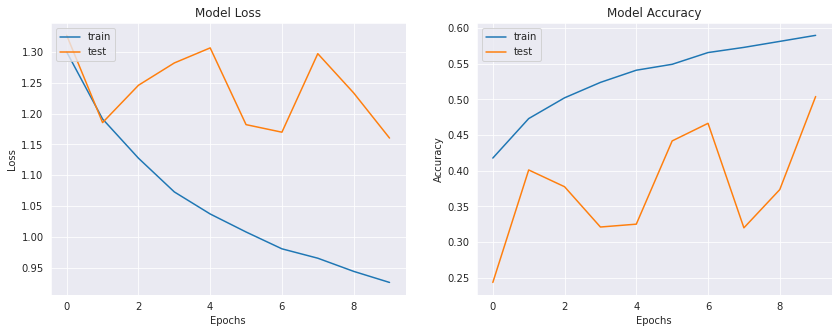

In [45]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

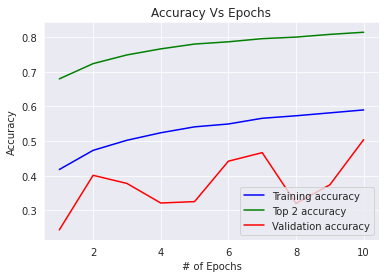

<Figure size 432x288 with 0 Axes>

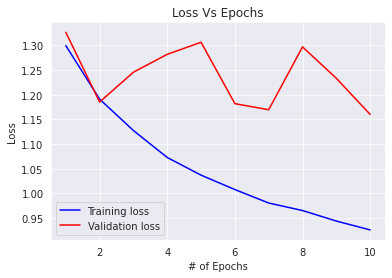

In [46]:
import seaborn as sb

sb.set_style("darkgrid")

Categorical_Acuracy = history.history['categorical_accuracy']
Top_2_Accuracy = history.history['top_2_accuracy']
Val_Categorical_Accuracy = history.history['val_categorical_accuracy']

Loss = history.history['loss']
Val_Loss = history.history['val_loss']

Epochs = range(1, len(Categorical_Acuracy) + 1)

#Train and validation accuracy
plt.plot(Epochs, Categorical_Acuracy, 'b', label='Training accuracy')
plt.plot(Epochs, Top_2_Accuracy, 'g', label='Top 2 accuracy')
plt.plot(Epochs, Val_Categorical_Accuracy, 'r', label='Validation accuracy')
plt.xlabel('# of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Vs Epochs')
plt.legend()

plt.figure()

plt.show()



print("\n\n")



#Train and validation loss



plt.plot(Epochs, Loss, 'b', label='Training loss')

plt.plot(Epochs, Val_Loss, 'r', label='Validation loss')

plt.xlabel('# of Epochs')

plt.ylabel('Loss')

plt.title('Loss Vs Epochs')

plt.legend()



plt.show()

Confusion Matrix
[[4782 3677 3396 4471 4310]
 [4783 3668 3424 4492 4269]
 [4803 3625 3345 4487 4376]
 [4764 3646 3310 4559 4357]
 [4610 3704 3367 4615 4340]]
Classification Report
              precision    recall  f1-score   support

           0       0.20      0.23      0.22     20636
           1       0.20      0.18      0.19     20636
           2       0.20      0.16      0.18     20636
           3       0.20      0.22      0.21     20636
           4       0.20      0.21      0.21     20636

    accuracy                           0.20    103180
   macro avg       0.20      0.20      0.20    103180
weighted avg       0.20      0.20      0.20    103180



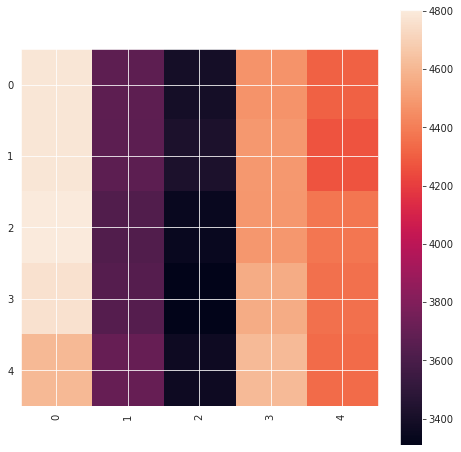

In [183]:
y_pred = model.predict(x_train)
y_pred = np.argmax(y_pred, axis=1)
class_labels = x_test.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(x_train.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(x_train.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [48]:
model.save("My_InceptionV3.h5")

In [144]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl
print(tf.__version__)


2.6.4


In [170]:
imagepath = '../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/1002_left.jpeg'

In [171]:
img = image.load_img(imagepath, target_size=(256, 256,3))

In [172]:
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

In [173]:
img_preprocessed = preprocess_input(img_batch)

In [174]:
prediction = model.predict(img_preprocessed)
prediction

array([[0., 1., 0., 0., 0.]], dtype=float32)

In [175]:
result = np.argmax(prediction)

In [176]:
classes = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

In [177]:
print("The predited class is: " + classes[result])

The predited class is: Mild DR


In [178]:
import cv2

image1 = cv2.imread(imagepath)
np.shape(image1)

(795, 1024, 3)

In [179]:
t_x.shape[1:]

(256, 256, 3)

In [180]:
image1.resize(1, 256, 256, 3)

In [181]:
np.shape(image1)

(1, 256, 256, 3)

In [182]:
print("The predited class is: " + classes[np.argmax(model.predict(image1))])

The predited class is: Mild DR
